In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import glob
from scipy import stats
import datetime as dt
from sklearn.neural_network import MLPClassifier

In [33]:
ACC   = pd.read_csv('46343_acceleration.txt', sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
HeartR = pd.read_csv('46343_heartrate.txt', sep = ',',names=['timedelta', 'heartrate'])
SleepL = pd.read_csv('46343_labeled_sleep.txt', sep = ' ',names=['timedelta', 'sleep'])


In [34]:
# Check 'timedelta' max(), min() of ACC, HeartR, SleepL (ช่วงเวลาที่มีข้อมูลใกล้กัน)
ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()
# หา start_timedelta, end_timedelta
HeartR_max = HeartR['timedelta'].max()
HeartR_min = HeartR['timedelta'].min()

SleepL_max = SleepL['timedelta'].max()
SleepL_min = SleepL['timedelta'].min()

print(f'ACC start: {ACC_min_date} ACC end: {ACC_max_date}')
print(f'HeartR start: {HeartR_min} HeartR end: {HeartR_max}')
print(f'SleepL start: {SleepL_min} SLeepL end: {SleepL_max}')

ACC start: -124489.16105 ACC end: 17643.046417
HeartR start: -556410.36066 HeartR end: 16980.47229
SleepL start: 0 SLeepL end: 16980


In [35]:
 # select only intersected timedelta (ACC, HeartR, SleepL) (ช่วงเวลาที่มีข้อมูลใกล้กัน) #เลือกขอบ
ACC_new = ACC[(ACC['timedelta'] > SleepL_min) & (ACC['timedelta'] < SleepL_max)]
HeartR_new = HeartR[(HeartR['timedelta']> SleepL_min) & HeartR['timedelta']< SleepL_max]
SleepL_new = SleepL[(SleepL['timedelta']> SleepL_min) & SleepL['timedelta']< SleepL_max]

In [36]:
ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))

C:\Users\Nuchtu\AppData\Local\Temp\ipykernel_19420\862878292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))


In [37]:
# Average rounding duplicated time
df_acc_X = ACC_new.groupby('timedelta')['accX'].mean().reset_index()
df_acc_Y = ACC_new.groupby('timedelta')['accY'].mean().reset_index()
df_acc_Z = ACC_new.groupby('timedelta')['accZ'].mean().reset_index()
ACC = pd.concat([df_acc_X, df_acc_Y, df_acc_Z], axis=1)
ACC = ACC.loc[:,~ACC.columns.duplicated()].copy() #ตัด duplicate columns(timedelta)
ACC

,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.243203,0.895372,0.367591
1,0 days 00:00:01,-0.240757,0.873826,0.415446
2,0 days 00:00:02,-0.244620,0.883943,0.387026
3,0 days 00:00:03,-0.248036,0.902427,0.347812
4,0 days 00:00:04,-0.241778,0.912946,0.321502
...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265


In [38]:
# ------------ Rounding Heart Rate (Rounding to 1 sec) -------------------------------
HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'],unit='s').round('1s'))

In [39]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()

In [40]:
# ------------ Rounding Sleep Label (Rounding to 1 sec) -------------------------------
SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'],unit='s').round('1s'))

In [41]:
#Resampling every 1s with median with ffill
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()
SleepL_new2


,sleep
timedelta,
0 days 00:00:00,-1.0
0 days 00:00:01,-1.0
0 days 00:00:02,-1.0
0 days 00:00:03,-1.0
0 days 00:00:04,-1.0
...,...
0 days 04:42:56,0.0
0 days 04:42:57,0.0
0 days 04:42:58,0.0


In [42]:
SleepL_new2.replace({-1:0},inplace=True)
SleepL_new2

,sleep
timedelta,
0 days 00:00:00,0.0
0 days 00:00:01,0.0
0 days 00:00:02,0.0
0 days 00:00:03,0.0
0 days 00:00:04,0.0
...,...
0 days 04:42:56,0.0
0 days 04:42:57,0.0
0 days 04:42:58,0.0


In [43]:
# ------------Merge All Data -------------------------------
df = []
df = pd.merge_asof(ACC, HeartR_new2, on='timedelta')
df = pd.merge_asof(df, SleepL_new2, on = 'timedelta')

In [44]:
# Fill NA
# Heart rate
# Fillna() # using median()
heart_mean = df.heartrate.mean()
df.heartrate.fillna(heart_mean,inplace=True)
# # Sleep Label
# Fillna() # with 0
df.sleep.fillna(0,inplace=True)
# # Drop column
df.drop(columns='timedelta',inplace=True)

In [45]:
#Standardized data
feature_columns = ['accX', 'accY', 'accZ', 'heartrate']
label_columns = ['sleep']
standard_scaler = StandardScaler()
df[feature_columns] = standard_scaler.fit_transform(df[feature_columns])

df_feature = df[feature_columns]
df_label = df[label_columns]
df_feature

,accX,accY,accZ,heartrate
0,-0.587547,3.058075,0.698728,0.788122
1,-0.581456,2.995094,0.757746,0.788122
2,-0.591075,3.024668,0.722696,0.788122
3,-0.599581,3.078699,0.674335,0.788122
4,-0.583998,3.109450,0.641889,0.788122
...,...,...,...,...
16976,-1.084456,-1.096565,1.136974,-0.630659
16977,-1.082531,-1.095348,1.137542,-0.630659
16978,-1.081511,-1.094296,1.138273,-0.630659
16979,-1.083260,-1.096440,1.137363,-0.630659


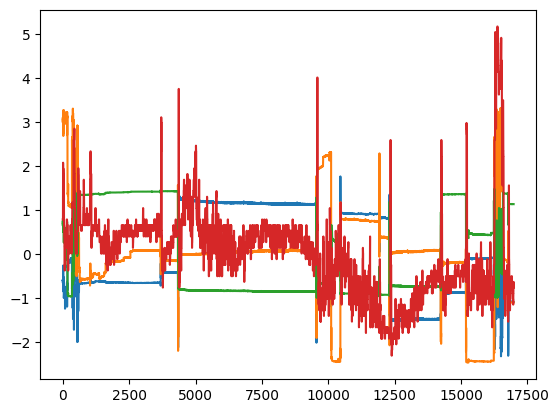

In [46]:
plt.plot([int(i) for i in range(len(df[feature_columns]))],df_feature)

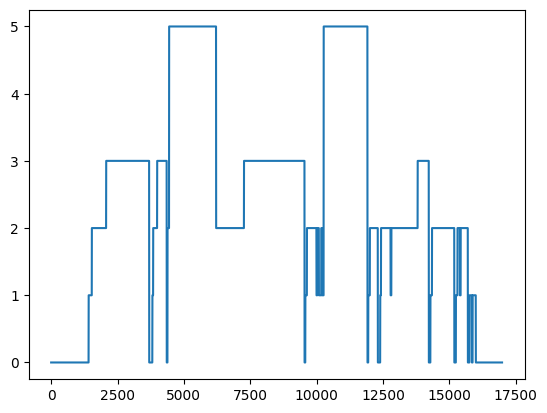

In [47]:
plt.plot([int(i) for i in range(len(df.heartrate))],df_label.sleep)

### Create 3d Input

In [48]:
# # ------------ 1D to 3D feature-------------------------------
# # set sliding window parameter
slidingW = 100
n_feature =4
stride_step = 5
df_feature3D = []
df_label_new = np.array([])                                         
for t in range( 0 , len(df_feature)-96, stride_step):     
    F3d= df_feature[t:t+ slidingW]                        
    df_feature3D.append(np.array(F3d)) 
    Labels = stats.mode(df_label[t : t+slidingW])
    df_label_new = np.append(df_label_new,Labels[0])
df_feature3D = np.array(df_feature3D).reshape(len(df_feature3D),slidingW,n_feature,1)
print(df_feature3D)


C:\Users\Nuchtu\AppData\Local\Temp\ipykernel_19420\1445178077.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  Labels = stats.mode(df_label[t : t+slidingW])


[[[[-0.58754699]
   [ 3.05807519]
   [ 0.69872824]
   [ 0.78812242]]

  [[-0.58145574]
   [ 2.99509378]
   [ 0.75774575]
   [ 0.78812242]]

  [[-0.59107524]
   [ 3.02466836]
   [ 0.72269623]
   [ 0.78812242]]

  ...

  [[-0.92104538]
   [ 3.14574551]
   [ 0.23209668]
   [ 0.40118204]]

  [[-0.91866235]
   [ 3.14714076]
   [ 0.23126907]
   [ 0.40118204]]

  [[-0.90930807]
   [ 3.15256736]
   [ 0.23283358]
   [ 0.14322179]]]


 [[[-0.63079638]
   [ 3.06967162]
   [ 0.66802186]
   [ 0.78812242]]

  [[-0.65623081]
   [ 3.03358303]
   [ 0.6929944 ]
   [ 0.78812242]]

  [[-0.61745949]
   [ 3.04996268]
   [ 0.70392346]
   [ 0.78812242]]

  ...

  [[-0.92642696]
   [ 3.14347961]
   [ 0.2498879 ]
   [ 0.27220192]]

  [[-0.92573315]
   [ 3.14479812]
   [ 0.24662261]
   [ 0.27220192]]

  [[-0.92884721]
   [ 3.14333154]
   [ 0.24502384]
   [ 0.27220192]]]


 [[[-0.63628057]
   [ 3.0250707 ]
   [ 0.71564591]
   [ 2.07792367]]

  [[-0.62761322]
   [ 3.01867796]
   [ 0.73035476]
   [ 2.07792367]]

  

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df_feature, df_label)

In [50]:
# ------------ Train-Test-Split 3D features -------------------------------
x3D_train, x3D_test, y3D_train, y3D_test = train_test_split( df_feature3D , df_label_new)

### NN Model Train Test

In [51]:
# ------------ NN Architecture parameter -------------------------------
Hidden_Layer_param = (30, 30, 30) 
mlp = MLPClassifier(hidden_layer_sizes = Hidden_Layer_param)
# # ------------ Training NN using 1D features -------------------------------

c:\Users\Nuchtu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [52]:
# ------------ Training NN using 1D features -------------------------------
mlp.fit(X_train,y_train)
mlp_pred = mlp.predict(X_test)

c:\Users\Nuchtu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [53]:
print('----- Confusion matrix of NN -----')
print(confusion_matrix(y_test,mlp_pred))
print('----- Classification matrix of NN -----')
print(classification_report(y_test,mlp_pred))

----- Confusion matrix of NN -----
[[ 630   19   63   16    2]
 [  27  118   86    4    8]
 [  20   48 1107   70   30]
 [   4    0   55 1085    1]
 [   1    0   21    0  831]]
----- Classification matrix of NN -----
              precision    recall  f1-score   support

         0.0       0.92      0.86      0.89       730
         1.0       0.64      0.49      0.55       243
         2.0       0.83      0.87      0.85      1275
         3.0       0.92      0.95      0.94      1145
         5.0       0.95      0.97      0.96       853

    accuracy                           0.89      4246
   macro avg       0.85      0.83      0.84      4246
weighted avg       0.89      0.89      0.89      4246



### CNN

In [54]:
# ------------ CNN Architecture parameter -------------------------------
# Nlayer (CNN, dense), Nnode, Activation
CNN_L1 = 16
CNN_L2 = 64
CNN_L3 = 128
D_L1 = 512
D_out = 6
Activation = 'relu'
Ker_size = (3,3)
Pooling_size = (2,1)
Input_shape = (slidingW, n_feature, 1)

In [55]:
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import MaxPooling2D,Dropout,Flatten,Dense,Conv2D
import tensorflow as tf
# ------------ Create CNN Model -------------------------------
model = Sequential()
 # ------------ Create CNN Model -------------------------------
model.add(Conv2D(CNN_L1, kernel_size=Ker_size, activation=Activation,input_shape=Input_shape,padding='same'))
model.add(MaxPooling2D(pool_size=Pooling_size)) 
model.add(Dropout(0.4)) 
model.add(Conv2D(CNN_L2, kernel_size=Ker_size, activation= Activation, padding='same'))
model.add(MaxPooling2D(pool_size= Pooling_size))
model.add(Dropout(0.4))
model.add(Conv2D(CNN_L3, kernel_size=Ker_size, activation= Activation, padding='same'))
model.add(MaxPooling2D(pool_size= Pooling_size))
model.add(Dropout(0.4))
model.add(Flatten())  
model.add(Dense(D_L1 , activation= Activation )) 
model.add(Dense(D_out, activation='sigmoid')) 
model.compile(optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 100, 4, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 4, 16)        0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 50, 4, 16)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 4, 64)         9280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 4, 64)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 25, 4, 64)        

In [56]:
model.compile(optimizer='adam',loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=["acc"])

In [57]:
# ------ Train CNN using 3D feature--------------------------------------------
history = model.fit(x3D_train, y3D_train, epochs=50, batch_size=64,validation_data=(x3D_test, y3D_test))

Epoch 1/50


c:\Users\Nuchtu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


40/40 [==============================] - 4s 93ms/step - loss: 1.1145 - acc: 0.5478 - val_loss: 0.7795 - val_acc: 0.6793
Epoch 2/50
40/40 [==============================] - 3s 87ms/step - loss: 0.6183 - acc: 0.7409 - val_loss: 0.6225 - val_acc: 0.7456
Epoch 3/50
40/40 [==============================] - 3s 83ms/step - loss: 0.5175 - acc: 0.7871 - val_loss: 0.5142 - val_acc: 0.8142
Epoch 4/50
40/40 [==============================] - 3s 76ms/step - loss: 0.4763 - acc: 0.7990 - val_loss: 0.4627 - val_acc: 0.8296
Epoch 5/50
40/40 [==============================] - 3s 76ms/step - loss: 0.4250 - acc: 0.8250 - val_loss: 0.4271 - val_acc: 0.8426
Epoch 6/50
40/40 [==============================] - 3s 75ms/step - loss: 0.4028 - acc: 0.8353 - val_loss: 0.4359 - val_acc: 0.8107
Epoch 7/50
40/40 [==============================] - 3s 76ms/step - loss: 0.3680 - acc: 0.8487 - val_loss: 0.3662 - val_acc: 0.8604
Epoch 8/50
40/40 [==============================] - 3s 76ms/step - loss: 0.3443 - acc: 0.8562 

In [58]:
# ------- Test CNN -------------------------------
CNN_pred = np.argmax(model.predict(x3D_test),axis=1)

27/27 [==============================] - 0s 11ms/step


### Performance of CNN Model

In [59]:
# ------------ View Confusion Matrix, Classification Report -------------------------------
print('----- Confusion matrix of NN -----')
print(confusion_matrix(y3D_test,CNN_pred))
print('----- Classification matrix of NN -----')
print(classification_report(y3D_test,CNN_pred))

----- Confusion matrix of NN -----
[[126   0   5   0   0]
 [  6  33  15   0   0]
 [  1   0 262   4   9]
 [  1   0   5 217   0]
 [  0   0   5   0 156]]
----- Classification matrix of NN -----
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       131
         1.0       1.00      0.61      0.76        54
         2.0       0.90      0.95      0.92       276
         3.0       0.98      0.97      0.98       223
         5.0       0.95      0.97      0.96       161

    accuracy                           0.94       845
   macro avg       0.95      0.89      0.91       845
weighted avg       0.94      0.94      0.94       845



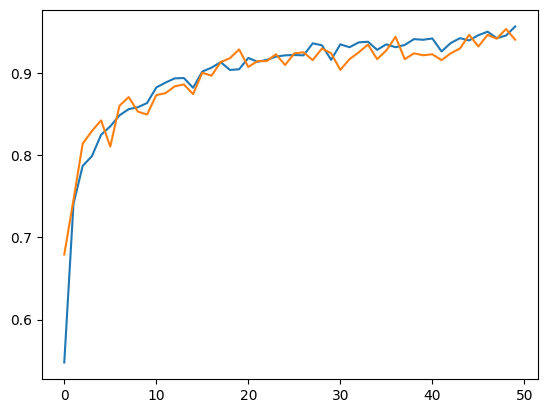

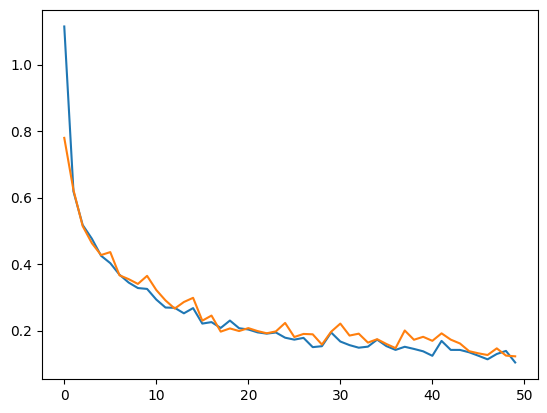

In [60]:
# ------ View History Graph -------------------------------------------
# View Accuracy Graph
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()
# View Loss Graph
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()